In [1]:
from utils.metrics import box_iou
import torch


import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import ipywidgets
from ipywidgets import interact
from tqdm import tqdm_notebook as tqdm
import os
from io import BytesIO
import cv2
import pandas as pd

In [2]:
proj = "Garbage_yolov5s_attn_with_sewage_ar0005_aug_15-02-2022"
training_data = "2022_02_14_with_sewage_ar0005"
eval_txt="eval_results.txt"
dist = {'02':97, '04':26}

In [3]:
# generate dataframe for evaluated results
with open('./inference/{}/{}'.format(proj, eval_txt), 'r') as f:
    lines = f.readlines()

data_dict = {k:[] for k in ['scene','num_img', 'P', 'R', 'mAP50', 'mAP95']}
with open('./tmp.txt','a') as f:
    for line in lines:
        splited = line.split(' ')
        new_line = [i for i in splited if i!='']
        if 'images' in new_line[0]:
            data_dict['scene'].append(new_line[0])
        elif 'all' in new_line[0]:
            data_dict['num_img'].append(new_line[2])
            data_dict['P'].append(new_line[-4])
            data_dict['R'].append(new_line[-3])
            data_dict['mAP50'].append(new_line[-2])
            data_dict['mAP95'].append(new_line[-1][:-1]) # [:-1] is to remove the '\n'

data = pd.DataFrame.from_dict(data_dict)

In [4]:
data

,scene,num_img,P,R,mAP50,mAP95
0,images/test,10055,0.866,0.755,0.839,0.647
1,images/test_tong_zhou,5576,0.907,0.675,0.809,0.58
2,images/test_xi_an,1622,0.795,0.699,0.766,0.565
3,images/test_huan_qiu,2264,0.909,0.918,0.958,0.807
4,images/test_tian_an,593,0.941,0.909,0.955,0.823
5,images/test_02,8916,0.82,0.739,0.809,0.628
6,images/test_04,9918,0.861,0.762,0.841,0.649
7,images/test_06,10053,0.866,0.756,0.839,0.647
8,images/test_24,1002,0.0799,0.698,0.0681,0.0472
9,images/test_46,135,0.00498,0.326,0.00329,0.00222


# generage visualizations

In [32]:
class report:
    def __init__(self, proj, training_data, img_w=640, img_h=480, iou=0.45, conf=0.25):
        self.training_data = training_data
        self.proj = proj
        self.img = None
        self.lbl = None
        self.pred_root = None
        self.pred = None
        self.FP = []
        self.FN = []
        self.correct = []
        self.correct_N=0
        self.img_w = img_w
        self.img_h = img_h
        self.iou_thresh = iou
        self.conf_thresh = conf
        
    def _reset(self):
        self.FP = []
        self.FN = []
        self.correct = []
        self.correct_N=0
        
        
    def generate(self, scene):
        self._reset()
        
        self.img = sorted(glob.glob('./dataset/{}/images/{}/*'.format(self.training_data, scene)))
        self.lbl = sorted(glob.glob('./dataset/{}/labels/{}/*'.format(self.training_data, scene)))
        self.pred_root = './inference/{}/{}/labels/'.format(proj,scene)
        self.pred = sorted(glob.glob(self.pred_root + '*'))
        
        print('img: {}, lbl: {}, pred: {}'.format(len(self.img), len(self.lbl), len(self.pred)))
        
        # calculate fpfns
        self.get_fpfn(scene)
        self.plot(scene)
        
    def get_fpfn(self, scene):

        for i, _ in enumerate(self.lbl):
            #print(self.lbl[i])
            with open(self.lbl[i], 'r') as f:
                gt_lines = f.readlines()
                gt_box = []
                for line in gt_lines:
                    cls, xc, yc, w, h = line.split(' ')

                    xc, yc, h, w = float(xc), float(yc), float(h), float(w)
                    xc, yc, h, w = int(self.img_w*xc), int(self.img_h*yc), int(self.img_h*h), int(self.img_w*w)

                    x1, y1, x2, y2 = xc-w//2, yc-h//2, xc+w//2, yc+h//2
                    gt_box.append([x1, y1, x2, y2])

            path, fname = os.path.split(self.lbl[i])
            pred_file = self.pred_root+fname
            pred_box = []
            if pred_file in self.pred:
                with open(pred_file, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        cls, conf, xc, yc, w, h = line.split(' ')
                        if float(conf)<=self.conf_thresh:continue
                        xc, yc, h, w = float(xc), float(yc), float(h), float(w)
                        xc, yc, h, w = int(self.img_w*xc), int(self.img_h*yc), int(self.img_h*h), int(self.img_w*w)

                        x1, y1, x2, y2 = xc-w//2, yc-h//2, xc+w//2, yc+h//2
                        
                        if '02' in scene:
                            if y1 >= dist['02']:
                                pred_box.append([x1, y1, x2, y2])
                        elif '04' in scene:
                            if y1 >= dist['04']:
                                pred_box.append([x1, y1, x2, y2])
                        elif '24' in scene:
                            if dist['04'] <y1<dist['02']:
                                pred_box.append([x1, y1, x2, y2])
                        elif '46' in scene:
                            if y1<dist['04']:
                                pred_box.append([x1, y1, x2, y2])
                        else:
                            pred_box.append([x1, y1, x2, y2])

            # compare iou and find out fp and fn
            if pred_box == [] and gt_box != []:
                for gtb in gt_box:
                    self.FN.append(gtb)
                    x1, y1, x2, y2 = gtb
                    #if (x2-x1)>50 or (y2-y1)>h > 50:
                        #print(i, w, h)
                    #print(i)
            elif gt_box == [] and pred_box == []:
                self.correct_N += 1
            elif gt_box == [] and pred_box != []:
                for pdb in pred_box:
                    self.FP.append(pdb)
                    #print(i)
            else:      
                for pdb in pred_box:
                    iou_fp = []
                    for gtb in gt_box:
                        iou_val = box_iou(torch.tensor(pdb).view(1,4), torch.tensor(gtb).view(1,4))
                        iou_fp.append(iou_val.item())
                    iou_fp = np.array(iou_fp)
                    # print(all(i < iou_thresh for i in iou_fp))
                    if all(i < self.iou_thresh for i in iou_fp): # false positive
                        self.FP.append(pdb)
                        #print(i)
                    else:
                        # means there is a gt box satisfy the iou_thresh
                        self.correct.append(pdb)

                for gtb in gt_box:
                    iou_fn = []
                    for pdb in pred_box:
                        iou_val = box_iou(torch.tensor(pdb).view(1,4), torch.tensor(gtb).view(1,4))
                        iou_fn.append(iou_val.item())
                    iou_fn = np.array(iou_fn)
                    if all(i < self.iou_thresh for i in iou_fn): # false negative
                        x1, y1, x2, y2 = gtb
                        #if (x2-x1)>50 or (y2-y1)>h > 50:
                        #    print(i, w, h)
                        self.FN.append(gtb)
                        #print(i)
        
        
    def plot(self, scene):
        tp = len(self.correct)
        fp = len(self.FP)
        fn = len(self.FN)
        tn = self.correct_N

        print(tp, fp, fn, tn)
        print('precision:{:.3f}, recall:{:.3f}'.format(tp/(tp+fp), tp/(tp+fn)))

        x = ["papershred_GT", "BG_GT"]
        y = ["papershred_Pred", "BG_Pred"]

        result = np.array([tp, fp, fn, np.NaN]).reshape(2,2)
        
        plt.figure(figsize=[25, 5])
        plt.suptitle("Evaluation for {}".format(scene), fontsize=22)
        plt.subplot(1,4,1)
        plt.imshow(result)

        # Show all ticks and label them with the respective list entries
        plt.xticks(np.arange(len(x)), labels=x, fontsize=12)
        plt.yticks(np.arange(len(y)), labels=y, fontsize=12)

        for i in range(len(x)):
            for j in range(len(y)):
                if i==len(x)-1 and j== len(y)-1:continue
                text = plt.gca().text(j, i, result[i, j],
                               ha="center", va="center", color="r", fontsize=16)

        # PNC plots
        plt.subplot(1,4,2)
        plt.imshow(np.ones((480,680,3)))
        plt.yticks([0, 26, 97, 480], ['0-6m','26-4m', '97-2m', '480-0.25m'], fontsize=12)

        fpy = []
        for box in self.FP:
            x1, y1, x2, y2 = box
            w, h = x2-x1, y2-y1
            rect = patches.Rectangle((x1, y1), 
                                     width=w, height=h,
                                     linewidth=1, edgecolor='red', facecolor='none')
            fpy.append(y1)
            plt.gca().add_patch(rect)
        plt.title('FP boxes spatial distribution')

        plt.subplot(1,4,3)
        plt.imshow(np.ones((480,680,3)))
        plt.yticks([0, 26, 97, 480], ['0-6m','26-4m', '97-2m', '480-0.25m'], fontsize=12)
        fny = []
        for box in self.FN:
            x1, y1, x2, y2 = box
            w, h = x2-x1, y2-y1
            rect = patches.Rectangle((x1, y1), 
                                     width=w, height=h,
                                     linewidth=1, edgecolor='blue', facecolor='none')
            fny.append(y1)
            plt.gca().add_patch(rect)
        plt.title('FN boxes spatial distribution')

        plt.subplot(1,4,4)
        plt.imshow(np.ones((480,680,3)))
        plt.yticks([0, 26, 97, 480], ['0-6m','26-4m', '97-2m', '480-0.25m'], fontsize=12)
        cy = []
        for box in self.correct:
            x1, y1, x2, y2 = box
            w, h = x2-x1, y2-y1
            rect = patches.Rectangle((x1, y1), 
                                     width=w, height=h,
                                     linewidth=1, edgecolor='green', facecolor='none')
            cy.append(y1)
            plt.gca().add_patch(rect)
        plt.title('Correct boxes spatial distribution')

In [33]:
rp = report(proj, training_data)

----------------------------scene: test
img: 10894, lbl: 10894, pred: 5379
7656 1243 2398 5171
precision:0.860, recall:0.761
----------------------------scene: test_tong_zhou
img: 2727, lbl: 2727, pred: 1355
3769 379 1807 1212
precision:0.909, recall:0.676
----------------------------scene: test_xi_an
img: 1442, lbl: 1442, pred: 982
1147 308 475 361
precision:0.788, recall:0.707
----------------------------scene: test_huan_qiu
img: 5727, lbl: 5727, pred: 2441
2177 474 87 3221
precision:0.821, recall:0.962
----------------------------scene: test_tian_an
img: 998, lbl: 998, pred: 601
563 82 29 377
precision:0.873, recall:0.951
----------------------------scene: test_02
img: 10894, lbl: 10894, pred: 5379
6902 926 2013 5900
precision:0.882, recall:0.774
----------------------------scene: test_04
img: 10894, lbl: 10894, pred: 5379
7612 1222 2305 5211
precision:0.862, recall:0.768
----------------------------scene: test_06
img: 10894, lbl: 10894, pred: 5379
7656 1243 2396 5172
precision:0.86

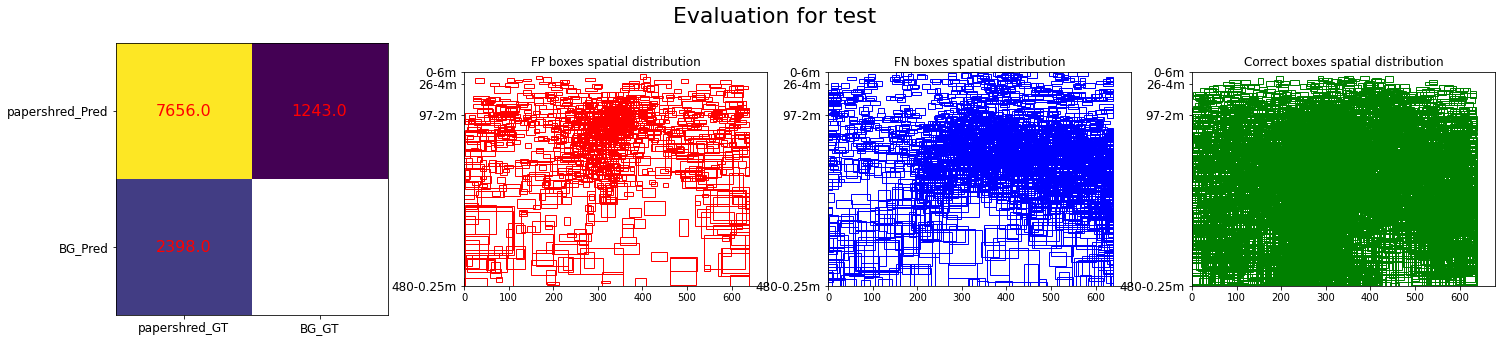

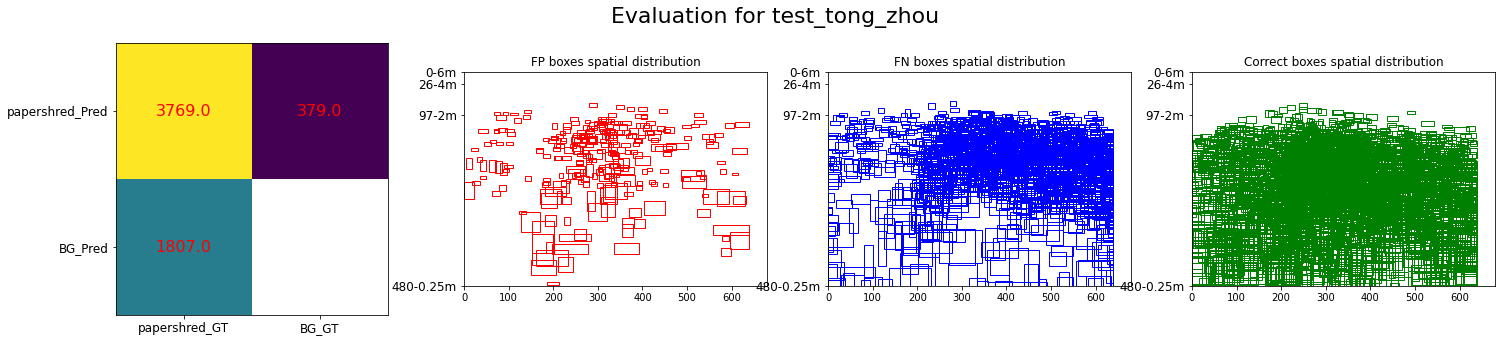

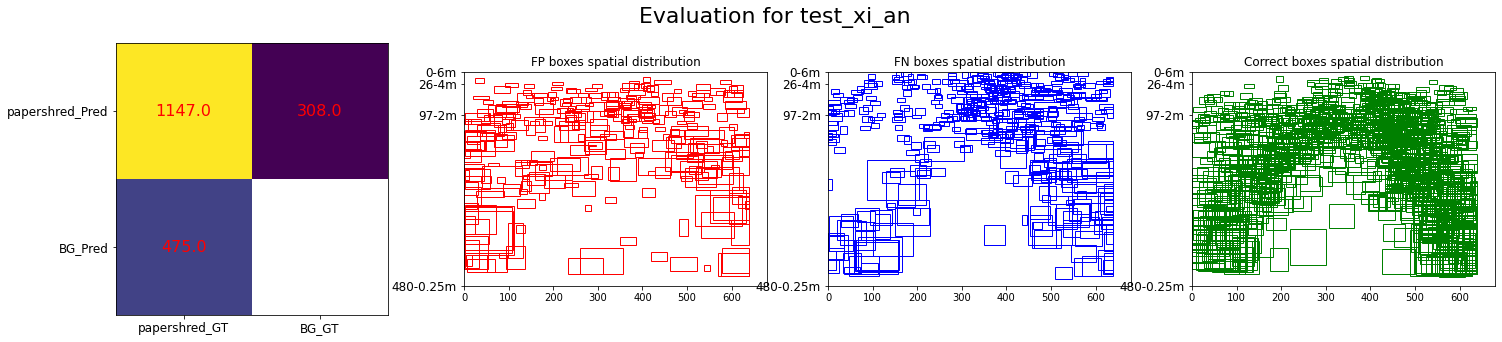

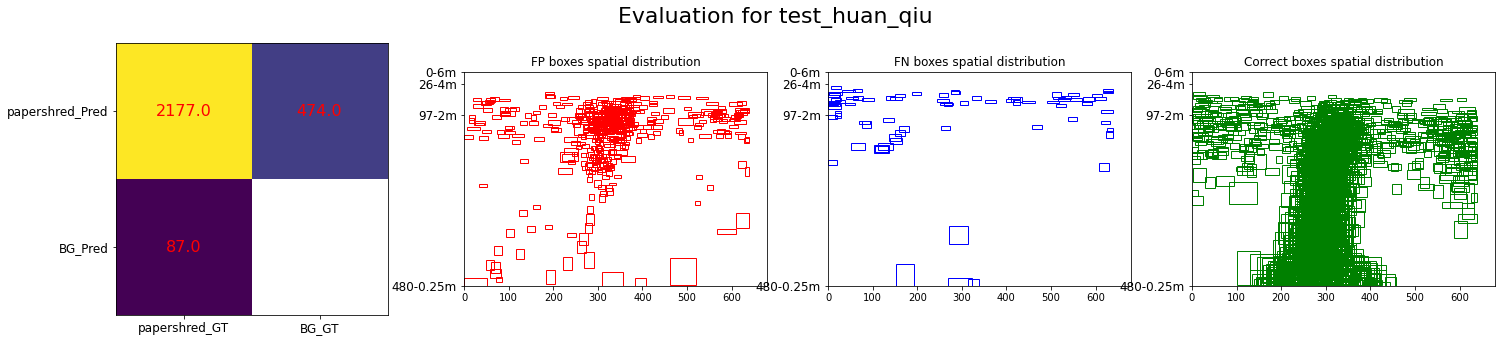

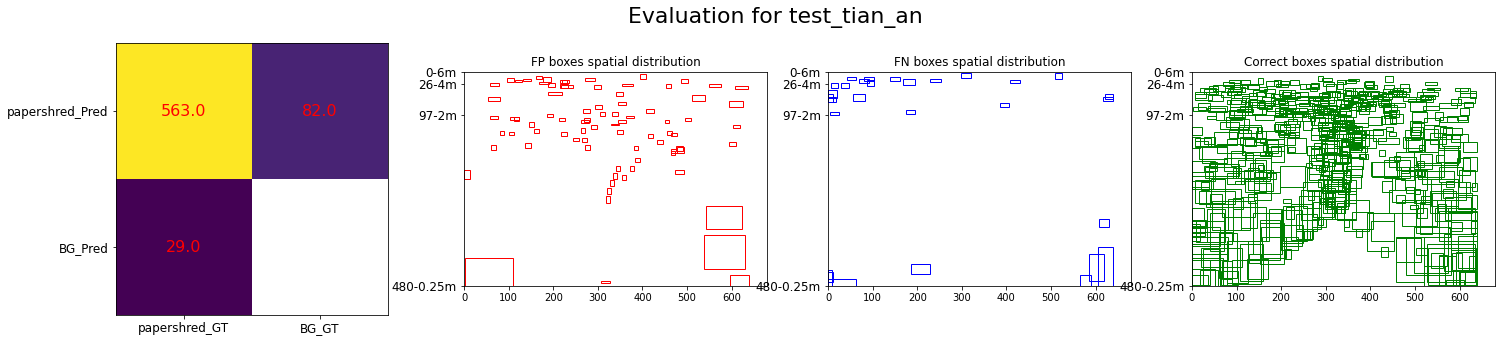

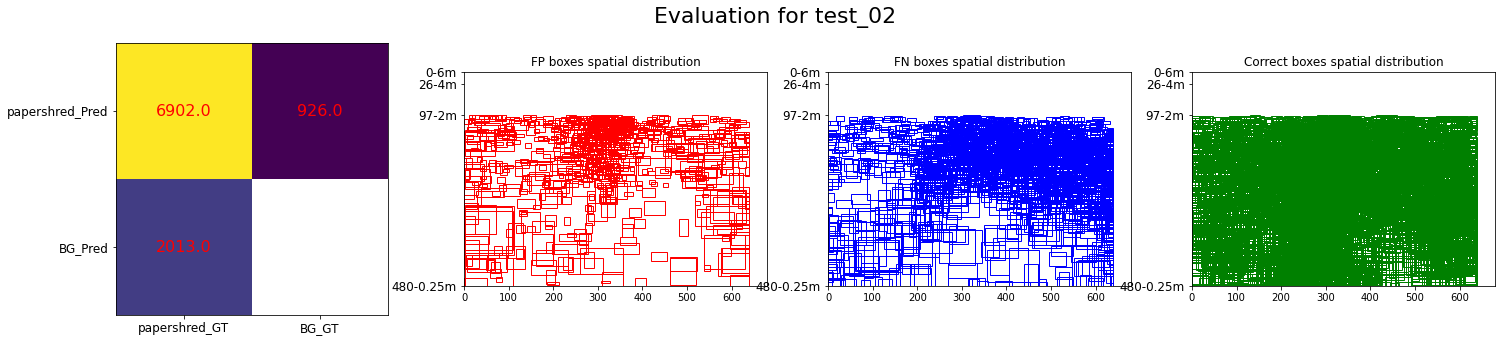

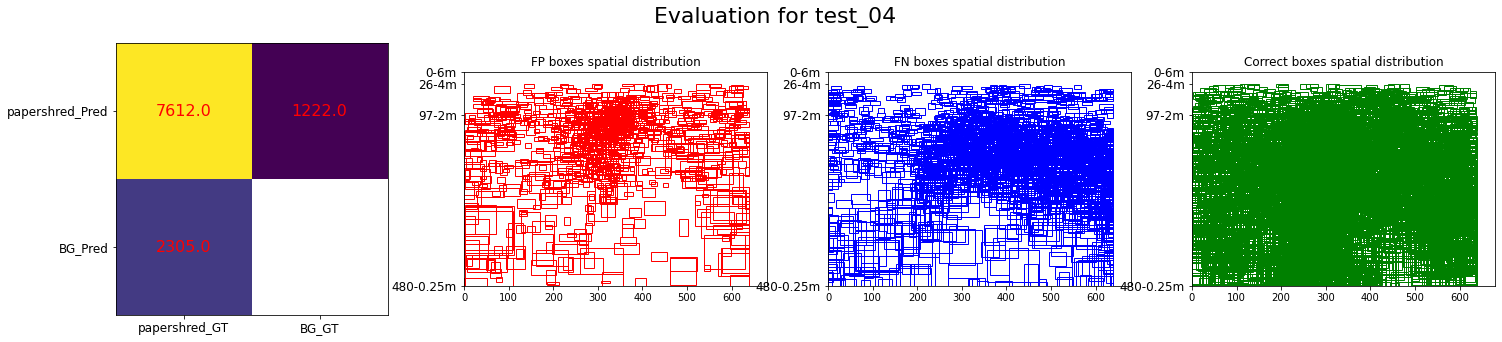

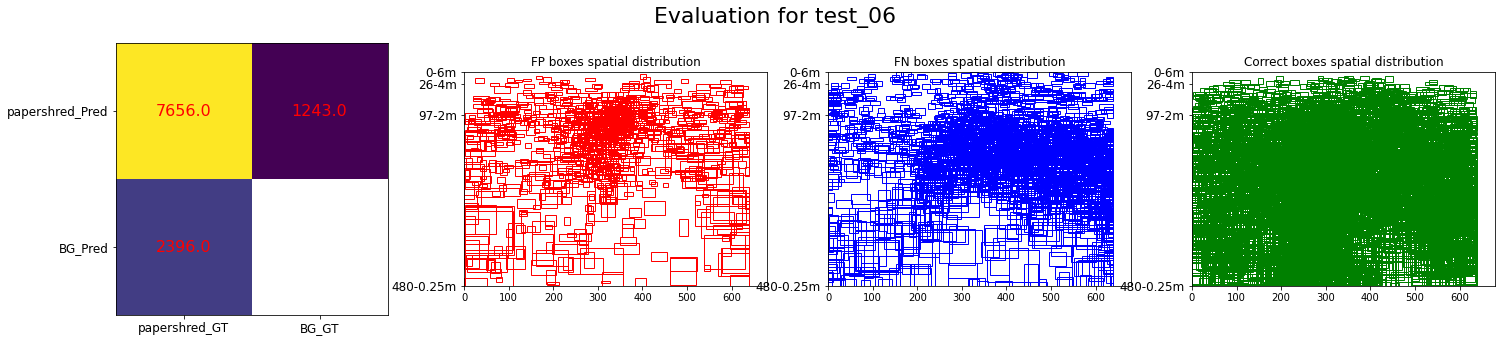

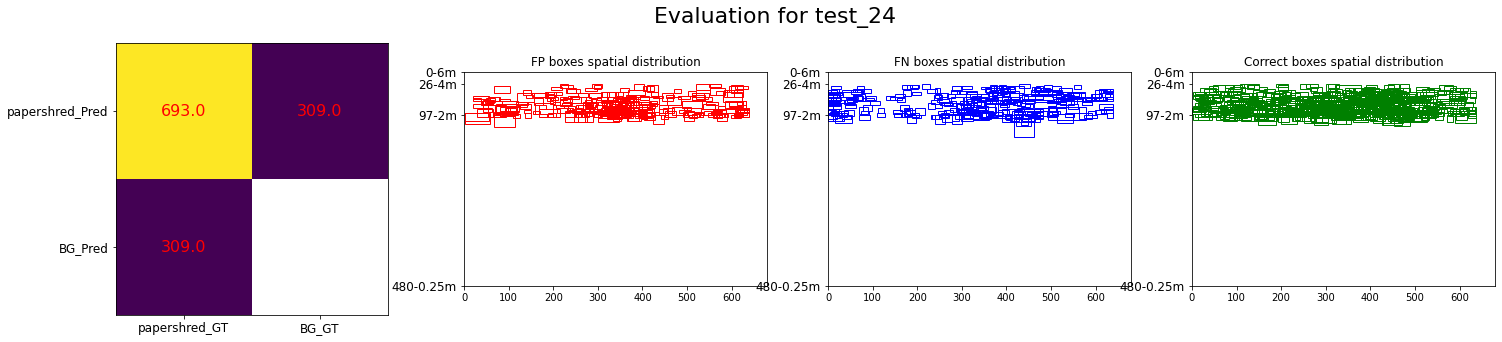

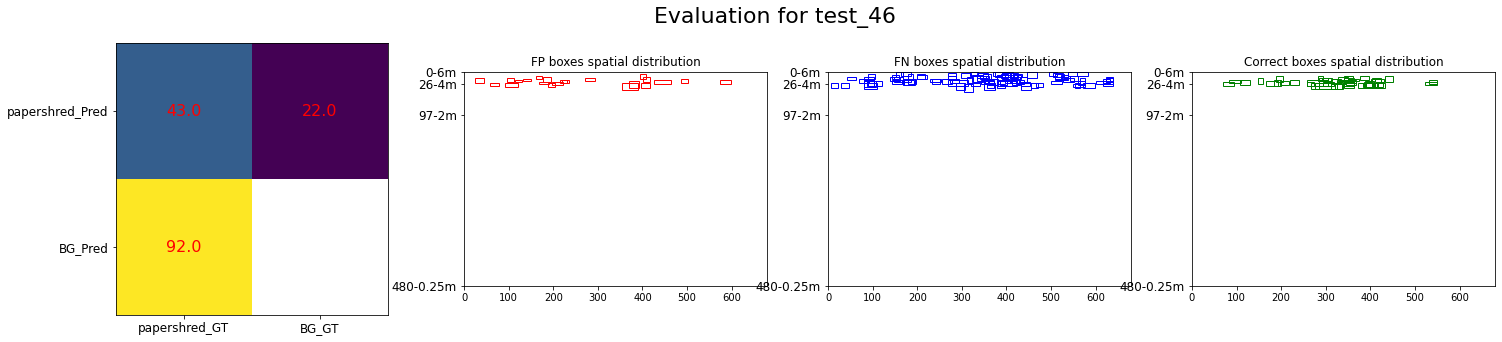

In [35]:
for scene in ["test", "test_tong_zhou", "test_xi_an", 
              "test_huan_qiu", "test_tian_an", "test_02", 
              "test_04", "test_06", "test_24", "test_46"]:
    print('----------------------------scene: {}'.format(scene))
    rp.generate(scene = scene)